# Słowem Wstępu
Robiąc ten projekt zachowywaliśmy się jak bezgłowe kurczaki. Żonglowaliśmy podejściami, zajmowały nas sidequesty (dashboard Gradio) a EDA powstawała równolegle z resztą projektu (a nie raz a dobrze na początku projektu). Wyszło jak wyszło, natomiast dużo się nauczyliśmy.

### Co kto robił
asujamuto:
- repo na githubie
- research algorytmów rekomendacji (implementacja bag of letters, tf-idf, word2vec z biblioteki gensim)
- próby włączenia zawartości obrazów do systemu rekomendacji (nie udało się tego zrobić w sensowny sposób ani w sensownym czasie)
- ostateczna wersja systemu rekomendacji

nimus100:
- data exploration
- dashboard Gradio do wizualizacji podpowiedzi (wybór kategorii interakcji, wybó minimalnej i maksymalnej ilości poprzednich interakcji użytkownika)
- podział zbioru treningowego na nasz własny zbiór treningowy i testowy (każda najnowsza interakcja to test, reszta to trening)
- kalkulacja MAP@10 w dashboardzie na podstawie naszych zbiorów: treningowego i testowego

### TF-IDF i jego ulepszenia
Sam algorytm TF-IDF (wrzucaliśmy tytuł + sklep + opis) nie dał zadowalających wyników (MAP@10 ~ 0.011). To samo widać było po wyodrębnieniu naszego zbioru treningowego i testowego. Po przyjrzeniu się danym zaproponowaliśmy następujące ulepszenia:

Ogólne:
- usuwanie już ocenionych przez użytkownika produktów z rekomendacji
- boostowanie wag najpopularniejszych produktów w ulubionej kategorii użytkownika (72% użytkowników ma tylko 2 interakcje)
- boostowanie wag produktów z topki danej kategorii które są semantycznie najbliższe do produktów już ocenionych przez użytkownika
- przemnożenie wyniku tf-idf z popularnością produktu i pewną wagą
Specyficzne dla aplikacji mobilnych:
- boostowanie gier tych samych wydawców co w historii użytkownika

### Ostateczna wersja
Algorytm bazuje na systemie rekomendacji popular-based z tego notebooka [link](https://www.kaggle.com/code/farizhaykal/recommendation-system-for-amazon-products#4.-Type-of-Recommender-System)


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Produkty

In [2]:
products = pd.read_csv("../data/item_metadata_filtered.csv")
# Ustawienie indeksu po "parent_asin" (jest unikalny)
products.set_index("parent_asin", inplace=True)

In [3]:
# PyCharm pokazuje fajne statystyki nad każdą kolumną
# Postaram się przedstawić najważniejsze
products

,main_category,title,average_rating,rating_number,price,store,features,description,images,categories,image_count,has_images,image_urls,category
parent_asin,,,,,,,,,,,,,,
B07WFSQXL5,All Beauty,PPY Eyelash Growth Serum – Natural Ingredients...,3.9,114.0,NaN,PPY,[],[],{'hi_res': array(['https://m.media-amazon.com/...,[],27,True,['https://m.media-amazon.com/images/I/615N6fkc...,All_Beauty
B08BV6F6BC,All Beauty,Wixar Natural Sea Moss Soap - (2 PACK) - Laven...,4.4,41.0,NaN,WIXAR NATURALS,[],[],{'hi_res': array(['https://m.media-amazon.com/...,[],21,True,['https://m.media-amazon.com/images/I/81ugegqe...,All_Beauty
B07Z818MLY,All Beauty,7 Packs Deep Wave Crochet Hair 22 Inch Deep wa...,3.4,10.0,NaN,Yun Mei Hair,[],[],{'hi_res': array(['https://m.media-amazon.com/...,[],21,True,['https://m.media-amazon.com/images/I/71aVcpK8...,All_Beauty
B071DY8Z4B,All Beauty,BEWAVE Hair Brush Sponge Twist With Comb Hair ...,4.2,24.0,NaN,BEWAVE,[],[],{'hi_res': array(['https://m.media-amazon.com/...,[],17,True,['https://m.media-amazon.com/images/I/61or2jYp...,All_Beauty
B0BTLTVR1X,All Beauty,"Zydeco Chop Chop Cajun Seasoning Base, 8 Ounce...",4.7,21.0,NaN,BORELTH,"['All Natural blend of Dehydrated Onion, Dehyd...",['Zydeco Chop Chop is a blend of Dehydrated On...,{'hi_res': array(['https://m.media-amazon.com/...,[],3,True,['https://m.media-amazon.com/images/I/71707mY6...,All_Beauty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B000NE85S2,NaN,Quicken Family Lawyer (CD-ROM),3.5,14.0,NaN,Parsons Technology,"[""America's Best-Selling Legal Software!""\n 'P...",['86 Forms in 10 categories: Estate Planning (...,"{'hi_res': array([None], dtype=object), 'large...",['Software' 'Business & Office' 'Legal'],2,True,['https://m.media-amazon.com/images/I/41+rSEEa...,Software
B076NZT5VY,Software,Ubuntu 16.04 Linux Desktop - 32-Bit 64-Bit Sup...,3.7,4.0,NaN,BrownTech PC System Tools,['Ubuntu 16.04 Linux on 2 Disc DVD Set 32 Bit ...,"['Ubuntu 16.04 ""Xenial Xerus"" 64-BIT & 32BIT L...",{'hi_res': array(['https://m.media-amazon.com/...,['Software' 'Linux' 'Operating Systems & Utili...,18,True,['https://m.media-amazon.com/images/I/71QlusvD...,Software
B001FSG0TQ,NaN,The Print Shop: Labels and Logos 2009,2.3,4.0,NaN,Encore,['Drag-and-drop design tools' 'Photo-realistic...,['Everything you need to create impressive lab...,"{'hi_res': array([None], dtype=object), 'large...",['Software' 'Business & Office' 'Office Suites'],2,True,['https://m.media-amazon.com/images/I/51xSHvST...,Software


In [5]:
# Drop rows with missing main_category
category_counts = (
    products.dropna(subset=["main_category"])
    .groupby("main_category")
    .size()
    .reset_index(name="item_count")
)

# Calculate percentage
total_items = category_counts["item_count"].sum()
category_counts["percentage"] = (category_counts["item_count"] / total_items * 100).round(2)

# Sort by item count descending
category_counts = category_counts.sort_values(by="item_count", ascending=False).reset_index(drop=True)

# Display the table
category_counts

,main_category,item_count,percentage
0,Appstore for Android,43463,55.92
1,All Beauty,17952,23.10
2,Health & Personal Care,10716,13.79
3,Software,5471,7.04
4,Premium Beauty,111,0.14
5,Gift Cards,4,0.01
6,Computers,2,0.00
7,Home Audio & Theater,1,0.00


# Interakcje (oceny produktów)

In [7]:
interactions = pd.read_csv("../data/train.csv")

In [10]:
import json

with open("../data/id_mappings.json") as f:
    id_map = json.load(f)

item_reverse_mapping = id_map["item_reverse_mapping"]  # maps int -> ASIN
item_id_to_asin = {int(k): v for k, v in item_reverse_mapping.items()}

In [11]:
interactions["asin"] = interactions["item_id"].map(item_id_to_asin)

In [12]:
print("Missing ASINs:", interactions["asin"].isna().sum())

Missing ASINs: 0


In [33]:
interactions_with_meta = interactions.merge(
    products[["main_category", "title", "average_rating", "rating_number", "store", "price"]],
    left_on="asin",
    right_index=True,
    how="left"
)

In [34]:
interactions_with_meta

,user_id,item_id,rating,timestamp,asin,main_category,title,average_rating,rating_number,store,price
0,0,7314,5.0,1353612262000,B006CQ8TC2,Appstore for Android,Turkey Season,3.5,304.0,"Gibbed Games, LLC",0.99
1,0,15493,5.0,1370653034000,B00B7S5FDG,Appstore for Android,Another Monster at the End of This Book...Star...,4.3,460.0,Sesame Workshop,3.99
2,0,18817,4.0,1373668644000,B00DRPVE3M,Appstore for Android,UNO ™ & Friends - The Classic Card Game Goes S...,3.9,11842.0,Gameloft,NaN
3,0,18251,4.0,1373669469000,B00D948SS0,Appstore for Android,World's Biggest Wordsearch - Your daily free w...,3.8,8290.0,Supersonic Software Ltd,0.00
4,0,16199,1.0,1375136041000,B00BQPEIT2,Appstore for Android,Temple Run: Oz,4.0,1043.0,Disney,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2543141,868216,15203,5.0,1397341480000,B00B1TGUMG,Software,Microsoft Office Home and Student 2013 (1PC/1U...,4.3,1759.0,Microsoft,NaN
2543142,868216,51839,5.0,1500036628141,B06XS4YRWX,Software,"NTI Echo 3, Make an exact copy of a HDD or SSD...",3.5,17.0,Nti,NaN
2543143,868217,14052,4.0,1464923235000,B00AB7HESI,Appstore for Android,Scribblenauts Remix,3.8,5520.0,Warner Bros,0.99
2543144,868217,40099,4.0,1465146950000,B014RGFC0K,Appstore for Android,Smashy Road: Wanted,3.6,7541.0,Bearbit Studios B.V.,0.00


In [18]:
# Drop rows with missing category
interactions_clean = interactions_with_meta.dropna(subset=["main_category"])

# Count interactions per main_category
category_counts_int = (
    interactions_clean
    .groupby("main_category")
    .size()
    .reset_index(name="interaction_count")
)

# Compute percentages
total_interactions = category_counts_int["interaction_count"].sum()
category_counts_int["percentage"] = (category_counts_int["interaction_count"] / total_interactions * 100).round(2)

# Sort by count descending
category_counts_int = category_counts_int.sort_values(by="interaction_count", ascending=False).reset_index(drop=True)

In [19]:
category_counts_int

,main_category,interaction_count,percentage
0,Appstore for Android,2298512,90.41
1,Software,102099,4.02
2,All Beauty,81010,3.19
3,Health & Personal Care,59839,2.35
4,Premium Beauty,813,0.03
5,Computers,33,0.00
6,Gift Cards,17,0.00
7,Home Audio & Theater,3,0.00


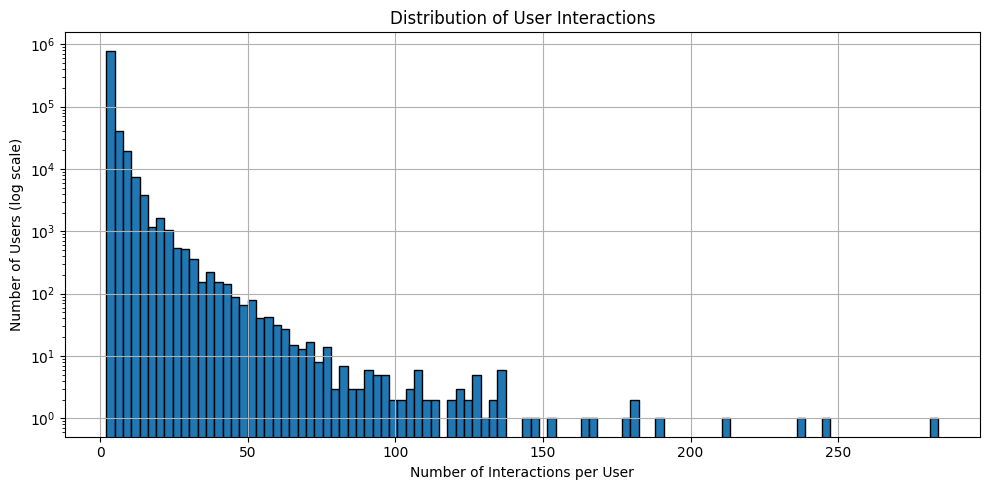

In [20]:
user_counts = interactions_with_meta["user_id"].value_counts()

plt.figure(figsize=(10, 5))
bars = plt.hist(user_counts, bins=100, log=True, edgecolor='black')
plt.title("Distribution of User Interactions")
plt.xlabel("Number of Interactions per User")
plt.ylabel("Number of Users (log scale)")
plt.grid(True)
plt.tight_layout()
plt.show()

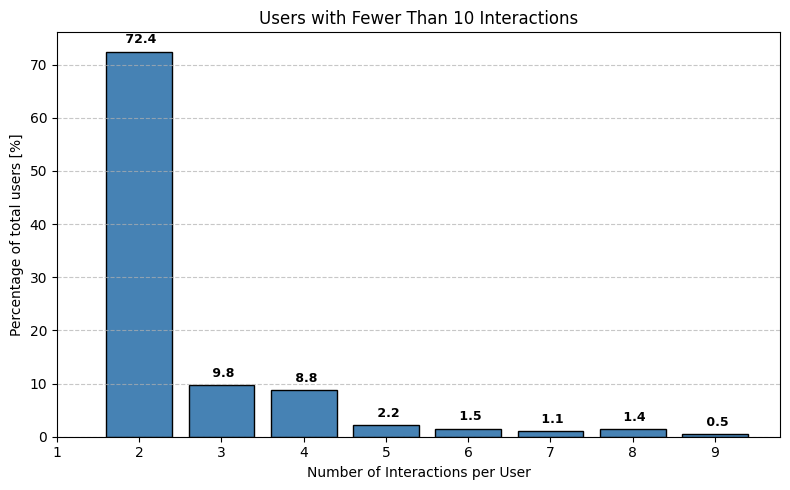

In [21]:
user_counts = interactions_with_meta["user_id"].value_counts()
total_len = len(user_counts)
filtered_counts = user_counts[user_counts < 10]
distribution = filtered_counts.value_counts().sort_index() / total_len * 100

plt.figure(figsize=(8, 5))
bars = plt.bar(distribution.index, distribution.values, color="steelblue", edgecolor="black")
for bar in bars: # Add labels above bars
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,
        f"{height: .1f}",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold"
    )
plt.xlabel("Number of Interactions per User")
plt.ylabel("Percentage of total users [%]")
plt.title("Users with Fewer Than 10 Interactions")
plt.xticks(range(1, 10))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

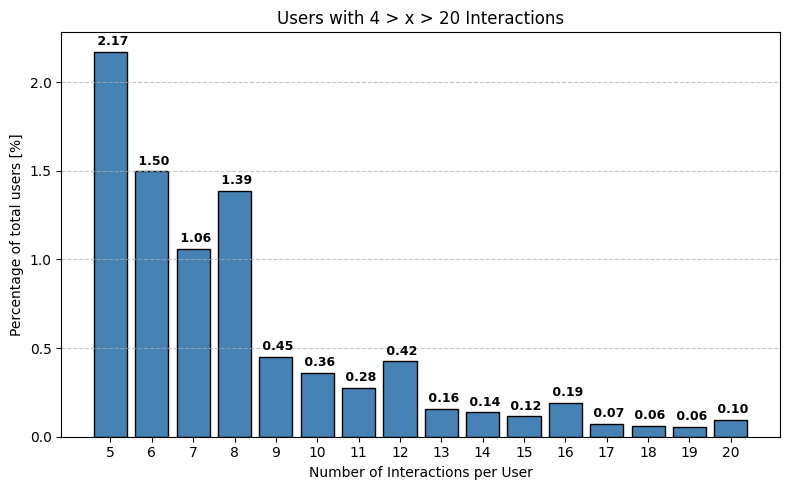

In [23]:
user_counts = interactions_with_meta["user_id"].value_counts()
total_len = len(user_counts)
filtered_counts = user_counts[(user_counts < 21) & (user_counts > 4)]
distribution = filtered_counts.value_counts().sort_index() / total_len * 100

plt.figure(figsize=(8, 5))
bars = plt.bar(distribution.index, distribution.values, color="steelblue", edgecolor="black")
for bar in bars: # Add labels above bars
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.02,
        f"{height: .2f}",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold"
    )
plt.xlabel("Number of Interactions per User")
plt.ylabel("Percentage of total users [%]")
plt.title("Users with 4 > x > 20 Interactions")
plt.xticks(range(5, 21))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Statystyki Interakcji Produktów

In [30]:
# Count interactions per item and main_category
top_products = (
    interactions_with_meta
    .dropna(subset=["main_category", "title"])  # Ensure valid data
    .groupby(["main_category", "title"])
    .size()
    .reset_index(name="interaction_count")
)

# Sort within each main_category and take top 10
top_10_per_category = (
    top_products
    .sort_values(["main_category", "interaction_count"], ascending=[True, False])
    .groupby("main_category")
    .head(10)
)

# Rank titles within each category
top_10_per_category["rank"] = top_10_per_category.groupby("main_category").cumcount()

# Pivot to wide format
top_10_popular = top_10_per_category.pivot(index="rank", columns="main_category", values="title")

# Reset index to make it a clean DataFrame
top_10_popular = top_10_popular.reset_index(drop=True)

In [31]:
top_10_popular

main_category,All Beauty,Appstore for Android,Computers,Gift Cards,Health & Personal Care,Home Audio & Theater,Premium Beauty,Software
0,Salux Nylon Japanese Beauty Skin Bath Wash Clo...,Candy Crush Saga,Norton by Symantec Granite Gray Norton Core Se...,TurboTax Deluxe + State 2019 Tax Software [Ama...,US Organic 100% Pure Peppermint Essential Oil ...,TurboTax Deluxe Federal + E-File + State 2012 ...,Tea Tree Lemon Sage Thickening Liter Duo Set,Kindle for Mac [Download]
1,"Godefroy Tint Kit for Spot Coloring, Dark Brown",Solitaire,Norton Core Secure WiFi Router | Built-in Netw...,TurboTax Deluxe + State 2019 Tax Software [Ama...,Glycerin Vegetable - 1 Quart (43 oz.) - Non GM...,NaN,Sol de Janeiro Brazilian Kiss Cupuaçu Lip Butter,[Old Version] TurboTax Deluxe Mac Fed + Efile ...
2,Harlorki Women's Bohemian Jewelry Statement Ne...,Minecraft,NaN,TurboTax Deluxe 2019 Tax Software [Amazon Excl...,GermGuardian Guardian Technologies GG10002PK G...,NaN,"ZOYA All Snuggled Up Quad,4 Count (Pack of 1)",[Old Version] TurboTax Deluxe + State 2019 Tax...
3,"DMSO Cream with Aloe Vera, 4 oz - Rose Scented...",Netflix,NaN,TurboTax Deluxe 2019 Tax Software [Amazon Excl...,Purple Back Cushion | Pressure Reducing Grid D...,NaN,Verb Ghost Shampoo & Conditioner Duo – Vegan S...,TurboTax Deluxe 2015 Federal + State Taxes + F...
4,GranNaturals Boar Bristle Smoothing Hair Brush...,YouTube,NaN,NaN,Avon SKIN-SO-SOFT Bug Guard PLUS IR3535® Insec...,NaN,PÜR Disappearing Ink 4-in-1 Brightening Concea...,Norton 360 2013 - 1 User / 3 PC [Old Version]
5,Bed Head Curve Check Curling Wand for Tousled ...,Facebook,NaN,NaN,"Mr Clean Magic Eraser Pads, 8 Count (Pack of 1)",NaN,"EltaMD Deep Pore Facial Cleanser, Sensitivity-...",Norton Security (For 5 Devices) [Download] (Ol...
6,"Helen of Troy 1511 Brush Iron, White, 3/4 Inch...",Crossy Road,NaN,NaN,"Carlson - The Very Finest Fish Oil, 1600 mg Om...",NaN,"Jack Black MP 10 Nourishing Oil, 2 Fl Oz",TurboTax Premier Federal + E-File + State 2012...
7,Segbeauty empty bottle 160083,Subway Surfers,NaN,NaN,Nerdwax Stop Slipping Glasses as Seen on Shark...,NaN,amika plus size perfect body mousse,Intuit TurboTax Premier 2015 Federal + State T...
8,Easy Feet Foot Cleaner,Township,NaN,NaN,Puffs Plus Lotion Facial Tissue (Old),NaN,"Bio Ionic Universal Diffuser, 1 Count",[Old Version] TurboTax Home & Business Desktop...
9,Collapsible Hair Diffuser by The Curly Co. wit...,Minion Rush: Running game,NaN,NaN,ASUTRA Natural & Organic Yoga Mat Cleaner (Min...,NaN,ColorProof SuperRich Moisture Shampoo to Hydra...,[Old Version] TurboTax Deluxe Tax Software 201...


In [37]:
# Filter to the target category
category = "Appstore for Android"
category_df = interactions_with_meta[interactions_with_meta["main_category"] == category]

# Total interactions in this category
total_interactions = len(category_df)

# Group by title and store to aggregate interactions and average rating
summary = (
    category_df
    .groupby(["title", "store", "price"], dropna=False)
    .agg(
        interaction_count=("user_id", "count"),
        avg_rating=("rating", "mean")
    )
    .reset_index()
)

# Compute percentage of all interactions
summary["percentage"] = (summary["interaction_count"] / total_interactions * 100).round(2)

# Round average rating
summary["avg_rating"] = summary["avg_rating"].round(2)

# Format interaction_count into k format
def format_k(n):
    return f"{n/1_000:.1f}k" if n >= 1_000 else str(n)

summary["interaction_count_k"] = summary["interaction_count"].apply(format_k)

# Sort and select top 20
top_20_apps = summary.sort_values(by="interaction_count", ascending=False).head(20)

# Reorder and rename columns
top_20_apps = top_20_apps[["title", "store", "price", "interaction_count_k", "percentage", "avg_rating"]]
top_20_apps.columns = ["Title", "Publisher", "Price", "Interactions", "% of Category", "Avg Rating"]

In [38]:
top_20_apps

,Title,Publisher,Price,Interactions,% of Category,Avg Rating
6416,Candy Crush Saga,King,0.00,28.3k,1.23,4.33
24013,Minecraft,Mojang,6.99,22.8k,0.99,4.54
25937,Netflix,"Netflix, Inc",0.00,18.0k,0.78,4.35
12842,Facebook,Facebook,0.00,16.4k,0.71,3.50
9296,Crossy Road,Hipster Whale,0.00,14.8k,0.64,4.62
34903,Subway Surfers,SYBO Games,0.00,13.0k,0.57,4.58
33482,Solitaire,MobilityWare,0.00,12.3k,0.54,4.45
37710,Township,Playrix,0.00,12.2k,0.53,4.39
24071,Minion Rush: Running game,Gameloft,0.00,11.6k,0.51,4.36
28257,Pinterest,"Pinterest, Inc",0.00,11.6k,0.50,4.53


# Podsumowanie

Pomysłów była kilka, w tym wykorzystanie wzoru: 
```WR = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C```
jednak liczenie go, dawało bardzo podobne wyniki dla użytkowników z takimi samymi kategoriami.
Prawdopodobnie tutaj kryło się rozwiązanie - niestety odkryliśmy to zbyt późno.


Projekt ten pozwolił nam zdobyć cenną wiedzę i zainspirował nas do dalszego rozwoju w obszarze Data Science.